### Wprowadzenie

Układ Lorenza często pojawia się w pracach związanych z zagadnieniem predykcji z wykorzystaniem kwaternionów [*wpisać odnośniki do artykułów*]. W związku z powyższym w celach weryfikacyjnych zaproponowany model zastosowano również do tego układu. 

Układ (system) Lorenza, opisuje zmiany zachodzące w atmosferze pod wpływem promieniowania słonecznego, ogrzewającego powierzchnię Ziemi. Sam układ rozpatrywany jest w baniach z zakresu chaosu deterministycznego, który można traktować jako losowe zachowanie się przebiegów czasowych.

Systemy z zakresu teorii chaosu deterministycznego, wrażliwe są na warunki początkowe, niewielka ich zmiana może prowadzić w dłuższym horyzoncie do wielkich odchyleń. 

Przebiegi w układzie Lorenza charakteryzują się występowaniem atraktora tj. stan układu dynamicznego, do którego dąży układ.

**Układ Lorenza** (model opisujący zjawisko konwekcji termicznej w atmosferze)
$$
\dot{s}_L(t) = F(x(t)) 
$$
$$
s_L(t) = 
\begin{bmatrix}
x(t)\\ 
y(t)\\
z(t) 
\end{bmatrix}, 

F(x(t)) = 
\begin{bmatrix}
\sigma(y(t)-z(t))\\ 
\rho x(t) - y(t) - x(t)z(t)\\
x(t)y(t) - \beta z(t)
\end{bmatrix}
$$

Dla modelu konwekcji:

- $\sigma$ - liczba Prandtla charakteryzująca lepkość ośrodka,
- $\rho$ - liczba Rayleigha,
- $\beta$ - rozmiar obszaru, w którym zachodzi konwekcja.

Dla założonego modelu konwekcji $\sigma$ = 10, $\rho$=28, $\beta$=$\frac{8}{3}$

M. Busłowicz, *Analiza układu Lorenza niecałkowitego rzędu*, Wydział Elektryczny, Politechnika Białostocka, [http://yadda.icm.edu.pl/baztech/element/bwmeta1.element.baztech-article-BSW1-0104-0038]

---

In [ ]:
import numpy as np
import quaternion as qt
import library.utils as ut
import library.ulogReader as ur
import library.quaternionUtils as qu
import library.choleskyDecomposition as cd
import library.quaternionVisualization as qv

import library.lorenzAttractor as la

#### Generowanie krzywych Lorentza 

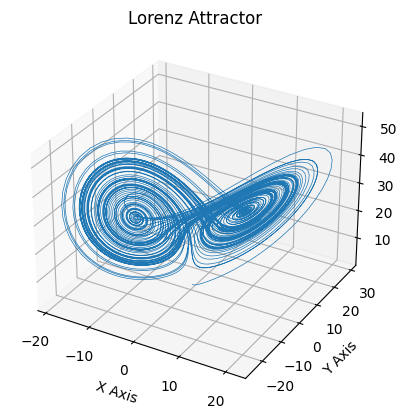

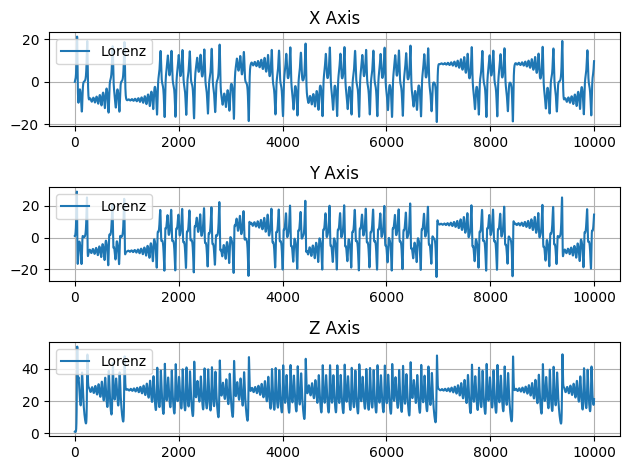

In [ ]:
dt = 0.01           # 1/frequency sampling
num_steps = 10000   # Number of steps

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)             # Set initial values

for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + la.lorenz(xyzs[i]) * dt

qv.displayLorenz([xyzs], ['Lorenz'])

## Modele predykcyjne
---

In [ ]:
P_ORDER = 5
K_FORECAST = [3]
DOWN_SAMPLING = 1 

### Metoda Yule-Walkera

In [ ]:
N_WINDOW = 8            # Minimal value (N_WINDOW > P_ORDER + 1)
START_WINDOW = 30
MU = 5e-3

x = qu.eulerToQuaternion(xyzs, degrees = True)[::DOWN_SAMPLING]
y_yule = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

corr_matrix = qu.correlationMatrix(x[:START_WINDOW][::-1], P_ORDER + 1 , normalize=True)

for i in range(START_WINDOW, x.shape[0]+1):
    tmp_corr_matrix = qu.correlationMatrix(x[i-N_WINDOW : i][::-1], P_ORDER + 1, normalize=True)
    corr_matrix = (1-MU) * corr_matrix + MU * tmp_corr_matrix
    tmp_corr_matrix = np.copy(corr_matrix)
    np.fill_diagonal(tmp_corr_matrix, tmp_corr_matrix.diagonal()+qt.quaternion(1e-6,0,0,0))
    l = cd.choleskyDecomposition(tmp_corr_matrix[:-1, :-1])
    w = cd.solveLLHEquation(l, tmp_corr_matrix[1:,0])

    for k, k_steps in enumerate(K_FORECAST):
        y_yule[k, i + k_steps - 1] = qu.predictionKSteps(np.copy(x[i-P_ORDER-1 : i][::-1]), np.concatenate(([qt.quaternion(1,0,0,0)],w)), k_steps)

### Metoda QLMS 

In [ ]:
MU = 1e-3

x = qu.eulerToQuaternion(xyzs, degrees = True)[::DOWN_SAMPLING]
y_qlms = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

w = qu.randQuaternionVector(P_ORDER)

for i in range(P_ORDER, x.shape[0]):
    s = x[i-P_ORDER : i][::-1]

    for k, k_steps in enumerate(K_FORECAST):
        y_qlms[k, i + k_steps - 1] = qu.predictionKSteps(s.copy(), w, k_steps)
    
    e_priori = x[i] - np.sum(w * s)
    w = w + MU * (2 * e_priori * s.conjugate() -      # Update coefficients
                  s.conjugate() * e_priori.conjugate() )

### Metoda RLS

In [ ]:
MU  = 1e-5
LMB = 0.85 

x = qu.eulerToQuaternion(xyzs, degrees = True)[::DOWN_SAMPLING]
y_rls = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

w = qu.randQuaternionVector(P_ORDER)

r = np.zeros((P_ORDER, P_ORDER), dtype=qt.quaternion)
g = np.zeros((P_ORDER, 1), dtype=qt.quaternion)
v = np.zeros((P_ORDER, 1), dtype=qt.quaternion)

for i in range(P_ORDER, x.shape[0]):
    s = x[i-P_ORDER : i][::-1].reshape(P_ORDER,1)

    for k, k_steps in enumerate(K_FORECAST):
        y_rls[k, i + k_steps - 1] = qu.predictionKSteps(np.copy(x[i-P_ORDER : i][::-1]), w, k_steps)

    e_priori = x[i] - np.sum(w * s)
    r = LMB * r + qu.quaternionMatrixMultiply(s, s.T.conjugate())
    g = LMB * g - s * e_priori
    v = qu.quaternionMatrixMultiply(r,g)
    alp = MU * np.sqrt(np.sum(qt.as_float_array(g)**2))
    w = w - g * alp
    g = g - v * alp

### Metoda rozdzielnych osi

In [ ]:
N_WINDOW = 8            # Minimal value (N_WINDOW > P_ORDER + 1)
START_WINDOW = 30
MU = 1e-3

x = qu.eulerToQuaternion(xyzs, degrees = True)[::DOWN_SAMPLING]
x_euler = qu.quaternionToEuler(x)
y_sep = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

pitch_corr = ut.correlationMatrixReal(x_euler[:START_WINDOW, 0][::-1], P_ORDER)
roll_corr  = ut.correlationMatrixReal(x_euler[:START_WINDOW, 1][::-1], P_ORDER)
yaw_corr   = ut.correlationMatrixReal(x_euler[:START_WINDOW, 2][::-1], P_ORDER)

for i in range(START_WINDOW, x.shape[0]+1):
    # Pitch 
    tmp_pitch_corr = ut.correlationMatrixReal(x_euler[i-N_WINDOW : i, 0][::-1], P_ORDER)
    pitch_corr = (1-MU) * pitch_corr + MU * tmp_pitch_corr
    p_w = ut.solveEquation(pitch_corr)

    # Roll 
    tmp_roll_corr = ut.correlationMatrixReal(x_euler[i-N_WINDOW : i, 1][::-1], P_ORDER)
    roll_corr = (1-MU) * roll_corr + MU * tmp_roll_corr
    r_w = ut.solveEquation(roll_corr)

    # Yaw 
    tmp_yaw_corr = ut.correlationMatrixReal(x_euler[i-N_WINDOW : i, 2][::-1], P_ORDER)
    yaw_corr = (1-MU) * yaw_corr + MU * tmp_yaw_corr
    y_w = ut.solveEquation(yaw_corr)


    for k, k_steps in enumerate(K_FORECAST):
        pitch = ut.kForecast(np.copy(x_euler[i-P_ORDER : i, 0][::-1]), p_w, k_steps)
        roll  = ut.kForecast(np.copy(x_euler[i-P_ORDER : i, 1][::-1]), r_w, k_steps)
        yaw   = ut.kForecast(np.copy(x_euler[i-P_ORDER : i, 2][::-1]), y_w, k_steps)
        y_sep[k, i + k_steps - 1] = qu.eulerToQuaternion([pitch, roll, yaw])[0]

    #q_w = qu.eulerToQuaternion(np.array(([p_w,r_w,y_w])).T)
    #for k, k_steps in enumerate(K_FORECAST):
    #    y[k, i + k_steps - 1] = qu.predictionKSteps(np.copy(x[i-P_ORDER-1 : i][::-1]), np.concatenate(([qt.quaternion(1,0,0,0)],q_w)), k_steps)


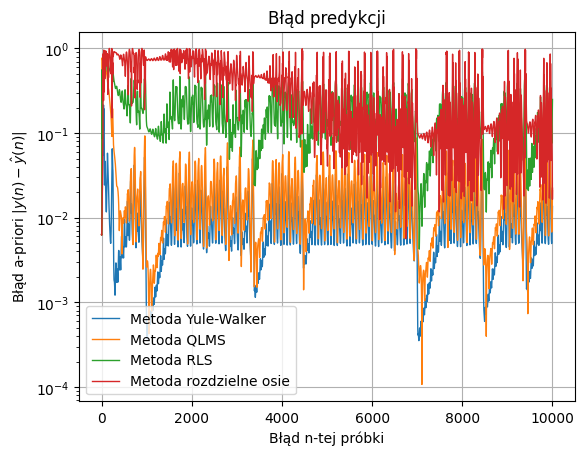

In [ ]:
qv.displayPredictionError(x,
                          np.array([y_yule[0], y_qlms[0], y_rls[0], y_sep[0]]),
                          ['Yule-Walker', 'QLMS', 'RLS', 'rozdzielne osie'],
                          label_form='Metoda {}')